# Aryan Bawa's Dalilab Dev Project!

I am approaching this problem using traditional image processing with OpenCV. I considered deep learning as well, but due to the limited dataset, I decided to stick with traditional methods. I will be using OpenCV to segment the green frame and crop the inner square. I will then use the cropped image to find the barnacles using a similar approach.

In [402]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

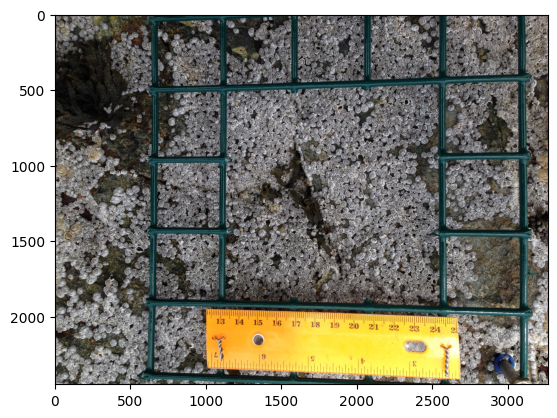

In [403]:
# loading the image
image = cv2.imread('Barnacles/img1.png')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)

This HSV conversion step comes in handy for images that are outside, as the standard BGR color space is more sensitive to variations in lighting conditions and shadows. Using HSV space should allow for more consistent color segmentation.

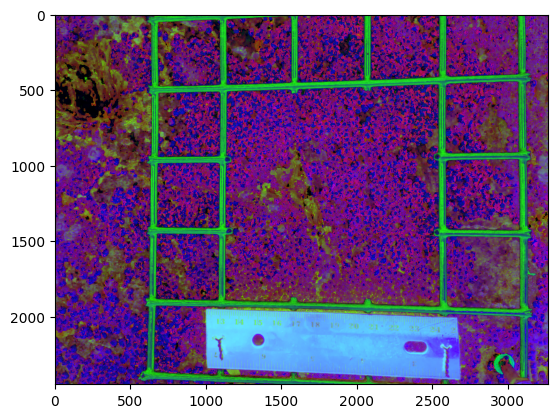

In [404]:
# converting to HSV color space for better color segmentation
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv)

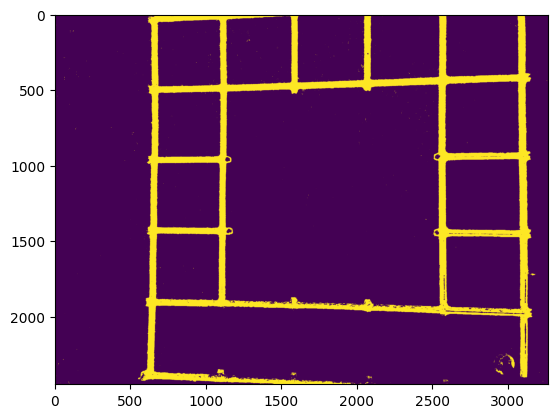

In [405]:
# defining range for green color in HSV
lower_green = np.array([10, 50, 0])
upper_green = np.array([35, 255, 255])

# creating a mask for the green frame
mask = cv2.inRange(hsv, lower_green, upper_green)
plt.imshow(mask)

I run into my first major problem here---the green frame has multiple square areas that I can pick from. The most problematic is the large outside perimeter which makes it so I can't simply pick the largest contour. Luckily, cv2.findContours outputs a list of all contours. I can sort this list and pick the second-largest contour which should be the large inner square. Its important that I take into account the case where the inner square is the largest contour. In this case, I will simply take the largest contour as the area.

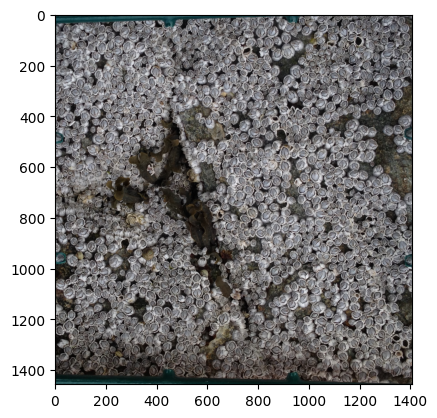

In [406]:
# defining the contours of the green frame
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sorting the contours by area
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Check to make sure there are at least 2 contours
if len(contours) < 2:
    print("No inner square found")
    # here you would return the only contour

# Assuming the region is the second-largest square
largest_contour = contours[1]
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the inner square
padding = 10  # To exclude the green frame itself
roi = image[y+padding:y+h-padding, x+padding:x+w-padding]
plt.imshow(roi)

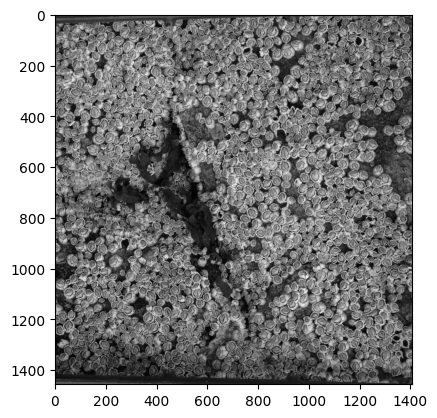

In [407]:
# Convert to grayscale and preprocess
gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

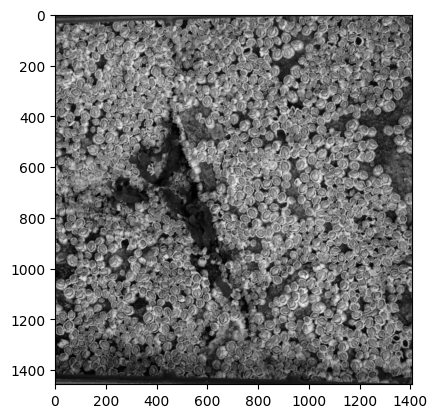

In [408]:
# can't use rn because it's causing edge blurring, need to tweak the settings
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

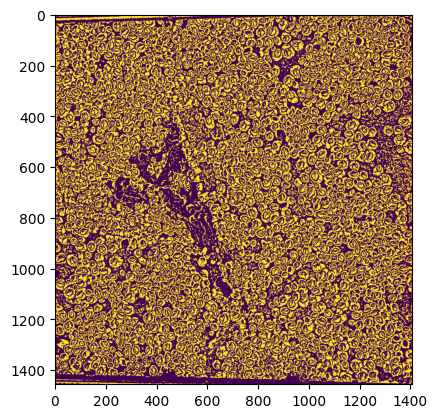

In [409]:
# gaussian-weighted adaptive thresholding
thresh = cv2.adaptiveThreshold(
    gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 31, -5
)

plt.imshow(thresh)

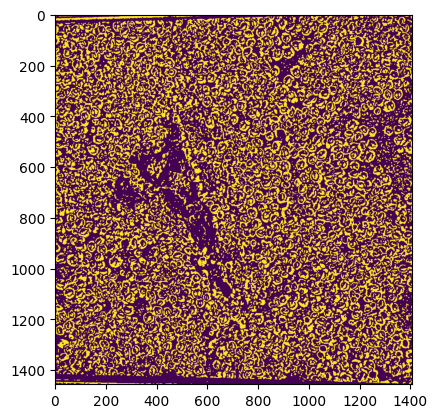

In [410]:
# Morphological operations to reduce noise
kernel = np.ones((3, 3), np.uint8)
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)  # Remove small noise
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)
dilated = cv2.dilate(closed, kernel, iterations=1)
cleaned = cv2.erode(dilated, kernel, iterations=1)
# Merge nearby regions

plt.imshow(cleaned)

In [411]:
# Find contours
contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    # Skip tiny/large regions
    if area < 500 or area > 10000:  # Example: barnacles are 10-200 pixels
        continue

    filtered.append(cnt)

print(len(filtered))


276


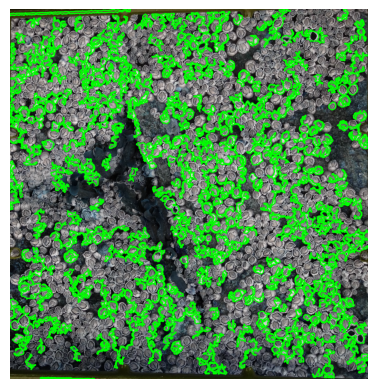

In [412]:
# copy the roi
roi_copy = roi.copy()

# Draw the contours on the original image
cv2.drawContours(roi_copy, filtered, -1, (0, 255, 0), 3)

# Convert the image from BGR to RGB
roic_rgb = cv2.cvtColor(roi_copy, cv2.COLOR_BGR2RGB)

# Display the image with contours
plt.imshow(roic_rgb)
plt.axis('off')  # Hide the axis
plt.show()

In [413]:
# image = cv2.imread('Barnacles/mask1.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# plt.imshow(image)
# plt.axis('off')  # Hide the axis
# plt.show()